In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [82]:
train_file = "./data/train.csv"
test_file = "./data/test.csv"

data_train = pd.read_csv(train_file, engine='python')
data_test = pd.read_csv(test_file, engine='python')

- - -
# Data
- 가장 먼저 데이터의 구조를 확인해보겠다.
- Null data를 확인해보고 어떻게 처리할 것인지의 대해 생각해보자.

In [83]:
display(data_train.head())
print('Data(train) shape : {}'.format(data_train.shape))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Data(train) shape : (1460, 81)


- 우리가 구하고자하는 label인 SalePrice의 그래프를 확인해보겠다.

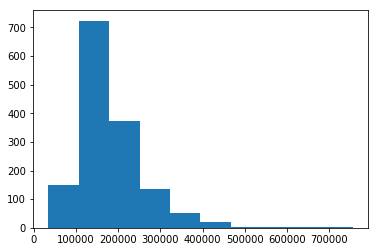

In [84]:
plt.hist(data_train.SalePrice)
plt.show()

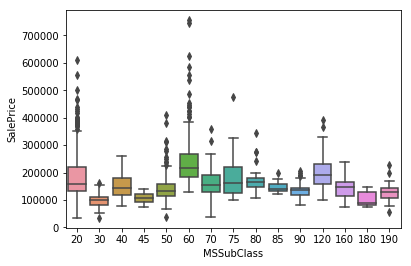

In [85]:
sns.boxplot(x='MSSubClass', y='SalePrice', data=data_train)

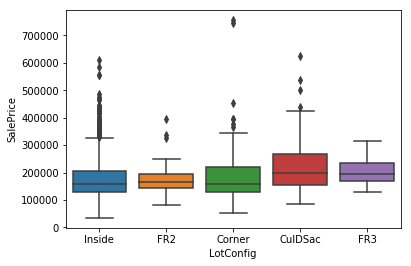

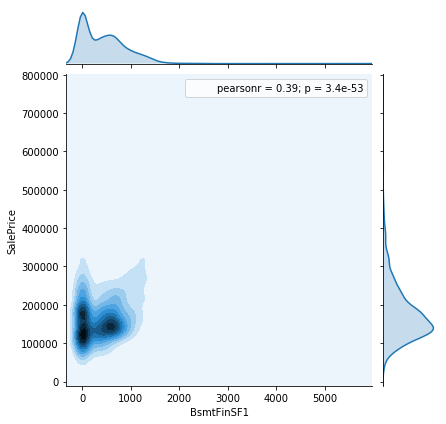

In [86]:
sns.boxplot(x='LotConfig', y='SalePrice', data=data_train)
sns.jointplot(x='BsmtFinSF1', y='SalePrice', data=data_train,kind='kde')

- - -
### Null 확인
-  column마다 null값의 개수를 확인
- null값으로 채워진 비율이 낮다면 해당 index를 삭제한다.(test dataset은 삭제하면 안된다!)
- null값으로 채워진 비율이 높다면 colunm을 삭제한다.
- null data를 어떻게 채우느냐에 따라 모델의 성능이 달라진다. 주어진 data를 간단히 분석해보자.

In [87]:
print('train dataset\n----------------')
tmp = data_train.isnull().sum()
for i in tmp.index:
    if tmp[i] != 0:
        print(i, tmp[i])

print('\n\ntest dataset\n----------------')
tmp = data_test.isnull().sum()
for i in tmp.index:
    if tmp[i] != 0:
        print(i, tmp[i])
        
print('\ntrain data shape : {}'.format(data_train.shape))
print('test data shape : {}'.format(data_test.shape))

train dataset
----------------
LotFrontage 259
Alley 1369
MasVnrType 8
MasVnrArea 8
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinType2 38
Electrical 1
FireplaceQu 690
GarageType 81
GarageYrBlt 81
GarageFinish 81
GarageQual 81
GarageCond 81
PoolQC 1453
Fence 1179
MiscFeature 1406


test dataset
----------------
MSZoning 4
LotFrontage 227
Alley 1352
Utilities 2
Exterior1st 1
Exterior2nd 1
MasVnrType 16
MasVnrArea 15
BsmtQual 44
BsmtCond 45
BsmtExposure 44
BsmtFinType1 42
BsmtFinSF1 1
BsmtFinType2 42
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
KitchenQual 1
Functional 2
FireplaceQu 730
GarageType 76
GarageYrBlt 78
GarageFinish 78
GarageCars 1
GarageArea 1
GarageQual 78
GarageCond 78
PoolQC 1456
Fence 1169
MiscFeature 1408
SaleType 1

train data shape : (1460, 81)
test data shape : (1459, 80)



train, test data 모두 Alley, PoolQC, Fence, MiscFeature에 대해 많은 결측값을 확인할 수 있었다.
<br>이 column와 SalePrice의 연관성을 확인해보고 학습에 영향을 많이 미치는지 생각해보자.

Alley
Grvl      50
None    1369
Pave      41
dtype: int64

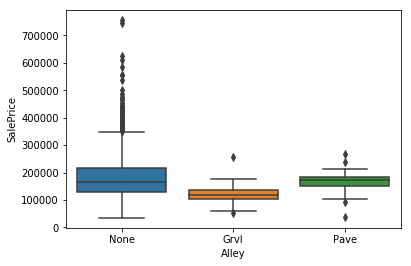

In [88]:
# 결측값을 'None' 이라는 category로 만들어준다.
data_train.Alley = data_train.Alley.fillna('None')
sns.boxplot(x='Alley', y='SalePrice', data=data_train)
display(data_train.groupby("Alley").size())

Alley의 Category마다 연관이 약간씩은 존재하지만 None이 1500개의 데이터 중 약 1400개를 차지한다.<br>
따라서 Alley columns을 drop하겠다.

In [89]:
data_train.drop(['Alley'], axis=1, inplace=True)
data_test.drop(['Alley'], axis=1, inplace=True)
display(data_train.shape)
display(data_test.shape)

(1460, 80)

(1459, 79)

Fence
GdPrv      59
GdWo       54
MnPrv     157
MnWw       11
None     1179
dtype: int64

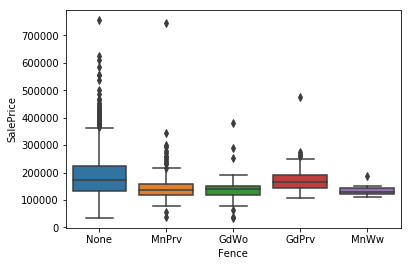

In [90]:
# 결측값을 'None' 이라는 category로 만들어준다.
data_train.Fence = data_train.Fence.fillna('None')
sns.boxplot(x='Fence', y='SalePrice', data=data_train)
display(data_train.groupby("Fence").size())

 Fence의 Category마다 연관이 약간씩은 존재하지만 None이 1500개의 데이터 중 약 1400개를 차지한다.
<br>따라서 Fence columns을 drop하겠다.

In [91]:
data_train.drop(['Fence'], axis=1, inplace=True)
data_test.drop(['Fence'], axis=1, inplace=True)
display(data_train.shape)
display(data_test.shape)

(1460, 79)

(1459, 78)

PoolQC
Ex         2
Fa         2
Gd         3
None    1453
dtype: int64

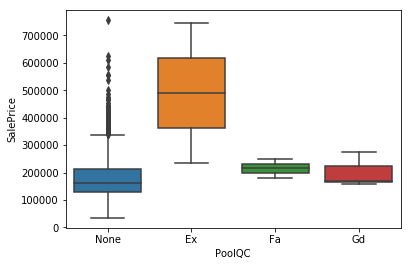

In [92]:
data_train.PoolQC = data_train.PoolQC.fillna('None')
sns.boxplot(x='PoolQC', y='SalePrice', data=data_train)
display(data_train.groupby("PoolQC").size())

 
PoolQC가 Ex인 경우 SalePrice가 높다는 것을 확인하였다. 하지만 Ex는 2개만 존재한다.<br>
따라서 PoolQC를 drop하겠다.

In [93]:
data_train.drop(['PoolQC'], axis=1, inplace=True)
data_test.drop(['PoolQC'], axis=1, inplace=True)
display(data_train.shape)
display(data_test.shape)

(1460, 78)

(1459, 77)

MiscFeature
Gar2       2
None    1406
Othr       2
Shed      49
TenC       1
dtype: int64

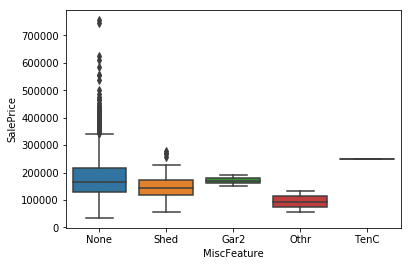

In [94]:
data_train.MiscFeature = data_train.MiscFeature.fillna('None')
sns.boxplot(x='MiscFeature', y='SalePrice', data=data_train)
display(data_train.groupby("MiscFeature").size())

 Fence의 Category마다 연관이 약간씩은 존재하지만 None이 1500개의 데이터 중 약 1400개를 차지한다.
<br>따라서 Fence columns을 drop하겠다.

In [95]:
data_train.drop(['MiscFeature'], axis=1, inplace=True)
data_test.drop(['MiscFeature'], axis=1, inplace=True)
display(data_train.shape)
display(data_test.shape)

(1460, 77)

(1459, 76)

 Id도 학습하는데에 전혀 연관이 없는 데이터이기 때문에 drop해준다.

In [96]:
#Save the 'Id' column
train_ID = data_train['Id']
test_ID = data_test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
data_train.drop("Id", axis = 1, inplace = True)
data_test.drop("Id", axis = 1, inplace = True)

 추가로 train data에서 Electrical column의 결측값이 딱 1개의 index에서만 발생하였기 때문에 해당 index를 삭제해주도록 하겠다.

In [97]:
# Electrical column에서의 결측값이 있는 index를 삭제
del_idx = data_train[data_train.Electrical.isnull() == True].index
data_train.drop(del_idx, axis = 0, inplace=True)

 방금 전 확인하였던 train data와 test data가 서로 빈 데이터를 가진 columns 자체가 다르다. 이로써 발생해주는 문제는 추후에 one-hot-encoding을 통해 categorical data를 dummy data로 만들었을때 서로 다른 columns을 가진 두개의 dataframe이 생긴다는 것이다. 따라서 이를 해결하기 위하여 먼저 처리해줄 내용은 아래와 같다.
 
 - train data 에서 label 값인 SalePrice를 미리 저장
 - train data와 test data를 merge
 - merge한 데이터에서 label인 SalePrice 제거
 - merge한 데이터에서 빈 데이터값을 확인하고 채워준 후에 다시 train data와 test data로 나누기

In [98]:
num_train = data_train.shape[0]
y_train = data_train.SalePrice

# 데이터를 합치고 index 재설정
data_all = pd.concat((data_train, data_test)).reset_index(drop=True)
display(data_all)

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,3,1Fam,TA,No,706.0,0.0,GLQ,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,3,1Fam,TA,Gd,978.0,0.0,ALQ,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,3,1Fam,TA,Mn,486.0,0.0,GLQ,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,3,1Fam,Gd,No,216.0,0.0,ALQ,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,4,1Fam,TA,Av,655.0,0.0,GLQ,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008
5,796,566,320,1,1Fam,TA,No,732.0,0.0,GLQ,...,WD,0,Pave,5,796.0,AllPub,40,1993,1995,2009
6,1694,0,0,3,1Fam,TA,Av,1369.0,0.0,GLQ,...,WD,0,Pave,7,1686.0,AllPub,255,2004,2005,2007
7,1107,983,0,3,1Fam,TA,Mn,859.0,32.0,ALQ,...,WD,0,Pave,7,1107.0,AllPub,235,1973,1973,2009
8,1022,752,0,2,1Fam,TA,No,0.0,0.0,Unf,...,WD,0,Pave,8,952.0,AllPub,90,1931,1950,2008
9,1077,0,0,2,2fmCon,TA,No,851.0,0.0,GLQ,...,WD,0,Pave,5,991.0,AllPub,0,1939,1950,2008


In [99]:
data_all.loc[17]

1stFlrSF            1296
2ndFlrSF               0
3SsnPorch              0
BedroomAbvGr           2
BldgType          Duplex
BsmtCond             NaN
BsmtExposure         NaN
BsmtFinSF1             0
BsmtFinSF2             0
BsmtFinType1         NaN
BsmtFinType2         NaN
BsmtFullBath           0
BsmtHalfBath           0
BsmtQual             NaN
BsmtUnfSF              0
CentralAir             Y
Condition1          Norm
Condition2          Norm
Electrical         SBrkr
EnclosedPorch          0
ExterCond             TA
ExterQual             TA
Exterior1st      MetalSd
Exterior2nd      MetalSd
FireplaceQu          NaN
Fireplaces             0
Foundation          Slab
FullBath               2
Functional           Typ
GarageArea           516
                  ...   
LotConfig         Inside
LotFrontage           72
LotShape             Reg
LowQualFinSF           0
MSSubClass            90
MSZoning              RL
MasVnrArea             0
MasVnrType          None
MiscVal              500


In [100]:
tmp = data_all.isnull().sum()
for i in tmp.index:
    if tmp[i] != 0:
        print(i, tmp[i])

BsmtCond 82
BsmtExposure 82
BsmtFinSF1 1
BsmtFinSF2 1
BsmtFinType1 79
BsmtFinType2 80
BsmtFullBath 2
BsmtHalfBath 2
BsmtQual 81
BsmtUnfSF 1
Exterior1st 1
Exterior2nd 1
FireplaceQu 1419
Functional 2
GarageArea 1
GarageCars 1
GarageCond 159
GarageFinish 159
GarageQual 159
GarageType 157
GarageYrBlt 159
KitchenQual 1
LotFrontage 486
MSZoning 4
MasVnrArea 23
MasVnrType 24
SalePrice 1459
SaleType 1
TotalBsmtSF 1
Utilities 2


 null값이 들어가있는 데이터를 확인하여 분석한 내용은 아래와 같다. -> 다음에 있는 값은 대체해줄 데이터이다.
 - Bsmt___ : (Category) -> 'None'
 - BsmtFinSF1 : FinType 1의 평방미터, Type1이 None인 경우 0.0으로 초기화되어있음 -> BsmtFinType1 isnull 확인 후 null이면 mean
 - BsmtFinSF2 : FinType 2의 평방미터, Type2이 None인 경우 0.0으로 초기화되어있음 -> BsmtFinType2 isnull 확인 후 null이면 mean
 - BsmtFullBath : fullbath 개수 -> 0.0
 - BsmtHalfBath : halfbath 개수 -> 0.0
 - BsmtUnfSF : Unfinished basement의 평방미터, 1개밖에 없으니 해당 index 삭제
 - Electrical : categorical data, None의 해당하는 data 없음, index 삭제
 - Exterior1st : categorical data, None의 해당하는 data 없음, index 삭제
 - Exterior2nd : categorical data, None의 해당하는 data 없음, index 삭제
 - FireplaceQu : 벽난로 품질(Category) -> 'None'
 - Functional :  categorical data, None의 해당하는 data 없음, index 삭제
 - GarageArea : 차고 넓이 (float) -> '0.0'
 - GarageCars : 차고에 차가 얼마나 들어가는지(Int) -> '0'
 - GarageCond : 차고 컨디션 -> 'None'
 - GarageFinish : 차고 내부공사 마무리 여부(Category) -> 'None'
 - GarageQual : 차고 품질(Category) -> 'None'
 - GarageType : 차고 타입(Category) -> 'None'
 - GarageYrBit : 차고 완공 년도(Int(year)) -> mean
 - KitchenQual : categorical data, None의 해당하는 data 없음, index 삭제
 - LotFrontage : 길과의 거리(float) -> mean
 - MSZoning : categorical data, None의 해당하는 data 없음, index 삭제
 - MasVnrType : 벽돌유형(Category) -> 'None'
 - MasVnrArea : 벽돌면적(float) -> mean
 - SaleType : index 삭제
 - TotalBsmtSF : index 삭제
 - Utilities : index 삭제
 
 
 

In [101]:
data_all.head(20)

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,3,1Fam,TA,No,706.0,0.0,GLQ,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,3,1Fam,TA,Gd,978.0,0.0,ALQ,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,3,1Fam,TA,Mn,486.0,0.0,GLQ,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,3,1Fam,Gd,No,216.0,0.0,ALQ,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,4,1Fam,TA,Av,655.0,0.0,GLQ,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008
5,796,566,320,1,1Fam,TA,No,732.0,0.0,GLQ,...,WD,0,Pave,5,796.0,AllPub,40,1993,1995,2009
6,1694,0,0,3,1Fam,TA,Av,1369.0,0.0,GLQ,...,WD,0,Pave,7,1686.0,AllPub,255,2004,2005,2007
7,1107,983,0,3,1Fam,TA,Mn,859.0,32.0,ALQ,...,WD,0,Pave,7,1107.0,AllPub,235,1973,1973,2009
8,1022,752,0,2,1Fam,TA,No,0.0,0.0,Unf,...,WD,0,Pave,8,952.0,AllPub,90,1931,1950,2008
9,1077,0,0,2,2fmCon,TA,No,851.0,0.0,GLQ,...,WD,0,Pave,5,991.0,AllPub,0,1939,1950,2008


In [102]:
data_all.BsmtFinSF1[data_all.BsmtFinSF1 == 0.0].index
# data_train.drop(['BsmtFinSF1'], axis=1, inplace=True)
# data_test.drop(['BsmtFinSF1'], axis=1, inplace=True)
# data_all.drop(['BsmtFinSF1'], axis=1, inplace=True)
# display(data_train.shape)
# display(data_test.shape)

Int64Index([   8,   13,   15,   17,   20,   21,   22,   25,   29,   30,
            ...
            2889, 2890, 2891, 2892, 2896, 2897, 2903, 2905, 2912, 2913],
           dtype='int64', length=928)

In [103]:
# data_train.drop(['BsmtFinSF2'], axis=1, inplace=True)
# data_test.drop(['BsmtFinSF2'], axis=1, inplace=True)
# data_all.drop(['BsmtFinSF2'], axis=1, inplace=True)
# display(data_train.shape)
# display(data_test.shape)

In [104]:
# BsmtFinSF1 : BsmtFinType1 isnull 확인 후 null이면 mean
data_all.BsmtFinSF1 = data_all.BsmtFinSF1.fillna(data_all.BsmtFinSF1.mean())

# BsmtFinSF2 : BsmtFinType2 isnull 확인 후 null이면 mean
data_all.BsmtFinSF2 = data_all.BsmtFinSF1.fillna(data_all.BsmtFinSF2.mean())

# BsmtFullBath : fullbath 개수 -> 0.0
data_all.BsmtFullBath = data_all.BsmtFullBath.fillna(0.0)

# BsmtHalfBath : halfbath 개수 -> 0.0
data_all.BsmtHalfBath = data_all.BsmtHalfBath.fillna(0.0)

# GarageArea : 차고 넓이 (float) -> '0.0'
data_all.GarageArea = data_all.GarageArea.fillna(0.0)

# GarageCars : 차고에 차가 얼마나 들어가는지(Int) -> '0'
data_all.GarageCars = data_all.GarageCars.fillna(0.0)

# GarageYrBit : 차고 완공 년도(Int(year)) -> mean
data_all.GarageYrBlt = data_all.GarageYrBlt.fillna(int(data_all.GarageYrBlt.mean()))


# LotFrontage : 길과의 거리(float) -> mean
data_all.LotFrontage = data_all.LotFrontage.fillna(data_all.LotFrontage.mean())

# MasVnrArea : 벽돌면적(float) -> mean
data_all.MasVnrArea = data_all.MasVnrArea.fillna(data_all.MasVnrArea.mean())

# BsmtUnfSF : Unfinished basement의 평방미터 -> mean
data_all.BsmtUnfSF = data_all.BsmtUnfSF.fillna(data_all.BsmtUnfSF.mean())

# Electrical : categorical data, None의 해당하는 data 없음
# Exterior1st : categorical data, None의 해당하는 data 없음
# Exterior2nd : categorical data, None의 해당하는 data 없음
# Functional : categorical data, None의 해당하는 data 없음
# KitchenQual : categorical data, None의 해당하는 data 없음
# MSZoning : categorical data, None의 해당하는 data 없음
# SaleType : Oth(other) 로 변경
data_all.SaleType = data_all.SaleType.fillna("Oth")

# TotalBsmtSF : 평방미터 -> mean
data_all.TotalBsmtSF = data_all.TotalBsmtSF.fillna(data_all.TotalBsmtSF.mean())

# fill nan to 'None'
data_all = data_all.fillna('None')

In [105]:


from scipy import stats
from scipy.stats import norm, skew #for some statistics

numeric_feats = data_all.dtypes[data_all.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = data_all[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    data_all[feat] = boxcox1p(data_all[feat], lam)


Skew in numerical features: 

There are 36 skewed numerical features to Box Cox transform


In [106]:
data_all.head(20)

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,11.692623,11.686189,0.000000,1.540963,1Fam,TA,No,11.170327,11.170327,GLQ,...,WD,0.000000,Pave,2.602594,11.692623,AllPub,0.000000,14.187527,14.187527,14.195323
1,12.792276,0.000000,0.000000,1.540963,1Fam,TA,Gd,12.062832,12.062832,ALQ,...,WD,0.000000,Pave,2.259674,12.792276,AllPub,9.010206,14.145138,14.145138,14.193765
2,11.892039,11.724598,0.000000,1.540963,1Fam,TA,Mn,10.200343,10.200343,GLQ,...,WD,0.000000,Pave,2.259674,11.892039,AllPub,0.000000,14.184404,14.185966,14.195323
3,12.013683,11.354094,0.000000,1.540963,1Fam,Gd,No,8.274266,8.274266,ALQ,...,WD,0.000000,Pave,2.440268,11.354094,AllPub,0.000000,14.047529,14.135652,14.192207
4,12.510588,12.271365,0.000000,1.820334,1Fam,TA,Av,10.971129,10.971129,GLQ,...,WD,0.000000,Pave,2.750250,12.510588,AllPub,8.013884,14.182841,14.182841,14.195323
5,11.493820,10.589574,9.178051,0.730463,1Fam,TA,No,11.267217,11.267217,GLQ,...,WD,0.000000,Pave,2.055642,11.493820,AllPub,4.969939,14.171884,14.175018,14.196881
6,13.670207,0.000000,0.000000,1.540963,1Fam,TA,Av,13.031093,13.031093,GLQ,...,WD,0.000000,Pave,2.440268,13.655781,AllPub,8.649311,14.189087,14.190647,14.193765
7,12.413831,12.077149,0.000000,1.540963,1Fam,TA,Mn,11.702249,11.702249,ALQ,...,WD,0.000000,Pave,2.440268,12.413831,AllPub,8.463564,14.140398,14.140398,14.196881
8,12.186751,11.339779,0.000000,1.194318,1Fam,TA,No,0.000000,0.000000,Unf,...,WD,0.000000,Pave,2.602594,11.987364,AllPub,6.448232,14.073384,14.103852,14.195323
9,12.335431,0.000000,0.000000,1.194318,2fmCon,TA,No,11.676516,11.676516,GLQ,...,WD,0.000000,Pave,2.055642,12.099929,AllPub,0.000000,14.086243,14.103852,14.195323


In [107]:
tmp = data_all.isnull().sum()

# nan값이 들어가있는 data가 있는지 확인하는 과정
for i in tmp.index:
    if tmp[i] != 0:
        print(i, tmp[i])

display(data_all.shape)

# #reindex
# data_all = data_all.reset_index(drop=True)

(2918, 76)

In [108]:
for i in data_all.keys():
    if data_all[i].dtype == 'int' or data_all[i].dtype == 'float':
            data_all[i] = (data_all[i] - data_all[i].mean())/data_all[i].std()
            
display(data_all.head())

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,-0.784689,1.214179,-0.112313,0.251255,1Fam,TA,No,0.799403,0.799403,GLQ,...,WD,-0.308207,Pave,1.015775,-0.073805,AllPub,-0.933702,1.041748,0.896134,0.157923
1,0.403194,-0.859795,-0.112313,0.251255,1Fam,TA,Gd,0.973570,0.973570,ALQ,...,WD,-0.308207,Pave,-0.212857,0.420981,AllPub,1.332506,0.160886,-0.390584,-0.602549
2,-0.569273,1.220996,-0.112313,0.251255,1Fam,TA,Mn,0.610116,0.610116,GLQ,...,WD,-0.308207,Pave,-0.212857,0.015922,AllPub,-0.933702,0.976846,0.848741,0.157923
3,-0.437869,1.155241,-0.112313,0.251255,1Fam,Gd,No,0.234252,0.234252,ALQ,...,WD,-0.308207,Pave,0.434186,-0.226124,AllPub,-0.933702,-1.867488,-0.678548,-1.363342
4,0.098904,1.318031,-0.112313,1.273273,1Fam,TA,Av,0.760530,0.760530,GLQ,...,WD,-0.308207,Pave,1.544803,0.294236,AllPub,1.081915,0.944374,0.753895,0.157923


- - -
# Categorical data 변환
 주어진 dataset의 feature들을 살펴보면 categorical data가 많이 존재한다. 이 데이터를 모델화시키고 학습시키기 위해서는 수치화하는 과정이 필요하다.
 <br>데이터들을 수치화하고 몇개의 field가 생성되는지 확인해보자.

In [109]:
# MSSubClass의 data는 categorical data이지만 int로 작성되어있다. 즉 이를 수치화하기 이전에 str로 변경하겠다.
data_all.MSSubClass = data_all.MSSubClass.apply(str)

In [110]:
data_all.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,-0.784689,1.214179,-0.112313,0.251255,1Fam,TA,No,0.799403,0.799403,GLQ,...,WD,-0.308207,Pave,1.015775,-0.073805,AllPub,-0.933702,1.041748,0.896134,0.157923
1,0.403194,-0.859795,-0.112313,0.251255,1Fam,TA,Gd,0.973570,0.973570,ALQ,...,WD,-0.308207,Pave,-0.212857,0.420981,AllPub,1.332506,0.160886,-0.390584,-0.602549
2,-0.569273,1.220996,-0.112313,0.251255,1Fam,TA,Mn,0.610116,0.610116,GLQ,...,WD,-0.308207,Pave,-0.212857,0.015922,AllPub,-0.933702,0.976846,0.848741,0.157923
3,-0.437869,1.155241,-0.112313,0.251255,1Fam,Gd,No,0.234252,0.234252,ALQ,...,WD,-0.308207,Pave,0.434186,-0.226124,AllPub,-0.933702,-1.867488,-0.678548,-1.363342
4,0.098904,1.318031,-0.112313,1.273273,1Fam,TA,Av,0.760530,0.760530,GLQ,...,WD,-0.308207,Pave,1.544803,0.294236,AllPub,1.081915,0.944374,0.753895,0.157923


 이제 categorical data를 one-hot-encoding 하기 전에 해주어야 하는 작업이 있다.
<br>SalePrice field에는 현재 train data에서 받아온 float와 test data에서 받아온 'None' 데이터가 동시에 존재한다.
<br>즉 one-hot-encoding을 진행하면 'None' index 때문에 float값까지 categorical data로 인식하여 굉장히 많은 field를 생성할 것이다.
<br>이를 막기위해 먼저 SalePrice field를 옮겨놓고 one-hot-encoding을 진행한 후에 다시 SalePrice df을 합치도록 하겠다.

In [111]:
# one-hot-encoding 전 saleprice 추출 후 저장
saleprice = data_all.SalePrice
data_all.drop("SalePrice", axis = 1, inplace = True)

In [112]:
saleprice.head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: object

data_all 에서 SalePrice field를 제거한 후에 one-hot-encoding을 통한 수치화를 진행한다.
<br>수치화를 진행하고는 SalePrice를 다시 merge하고 data_all을 data_train과 data_test로 다시 나누는 작업이 필요하다.

In [113]:
# one-hot-encoding
data_all = pd.get_dummies(data_all)

# SalePrice field를 다시 merge
data_all['SalePrice'] = saleprice

display(data_all[data_all.SalePrice != "None"].index)

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458],
           dtype='int64', length=1459)

In [114]:
data_train = data_all.loc[:1458]
data_test = data_all.loc[1459:]

data_test.drop("SalePrice", axis = 1, inplace = True)

display(data_train.head())
display(data_train.tail())
display(data_test.head())
display(data_test.tail())


,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa,Utilities_None,SalePrice
0,-0.784689,1.214179,-0.112313,0.251255,0.799403,0.799403,1.129973,-0.251374,-0.547956,-0.423910,...,0,0,0,1,0,1,1,0,0,208500
1,0.403194,-0.859795,-0.112313,0.251255,0.973570,0.973570,-0.833091,3.880135,-0.132294,-0.423910,...,0,0,0,1,0,1,1,0,0,181500
2,-0.569273,1.220996,-0.112313,0.251255,0.610116,0.610116,1.129973,-0.251374,0.167200,-0.423910,...,0,0,0,1,0,1,1,0,0,223500
3,-0.437869,1.155241,-0.112313,0.251255,0.234252,0.234252,1.129973,-0.251374,0.329240,2.903308,...,0,0,0,1,0,1,1,0,0,140000
4,0.098904,1.318031,-0.112313,1.273273,0.760530,0.760530,1.129973,-0.251374,0.256527,-0.423910,...,0,0,0,1,0,1,1,0,0,250000


,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa,Utilities_None,SalePrice
1454,-0.463130,1.114510,-0.112313,0.251255,-1.380425,-1.380425,-0.833091,-0.251374,0.776417,-0.423910,...,0,0,0,1,0,1,1,0,0,175000
1455,2.026707,-0.859795,-0.112313,0.251255,0.858516,0.858516,1.129973,-0.251374,0.395152,-0.423910,...,0,0,0,1,0,1,1,0,0,210000
1456,0.213682,1.363597,-0.112313,1.273273,0.341356,0.341356,-0.833091,-0.251374,0.708571,-0.423910,...,0,0,0,1,0,1,1,0,0,266500
1457,-0.087450,-0.859795,-0.112313,-1.016868,-0.341956,-0.341956,1.129973,-0.251374,-2.746905,2.178488,...,0,0,0,1,0,1,1,0,0,142125
1458,0.388184,-0.859795,-0.112313,0.251255,0.884808,0.884808,1.129973,-0.251374,-0.608199,-0.423910,...,0,0,0,1,0,1,1,0,0,147500


,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa,Utilities_None
1459,-0.648517,-0.859795,-0.112313,-1.016868,0.591574,0.591574,-0.833091,-0.251374,-0.166720,-0.42391,...,0,0,0,0,1,0,1,1,0,0
1460,0.566804,-0.859795,-0.112313,0.251255,0.942008,0.942008,-0.833091,-0.251374,0.118809,-0.42391,...,0,0,0,0,1,0,1,1,0,0
1461,-0.543248,1.119259,-0.112313,0.251255,0.859187,0.859187,-0.833091,-0.251374,-0.603727,-0.42391,...,0,0,0,0,1,0,1,1,0,0
1462,-0.549736,1.103498,-0.112313,0.251255,0.717310,0.717310,-0.833091,-0.251374,-0.041299,-0.42391,...,0,0,0,0,1,0,1,1,0,0
1463,0.447860,-0.859795,-0.112313,-1.016868,0.321268,0.321268,-0.833091,-0.251374,0.830074,-0.42391,...,0,0,0,0,1,0,1,1,0,0


,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa,Utilities_None
2913,-2.076379,1.003108,-0.112313,0.251255,-1.380425,-1.380425,-0.833091,-0.251374,0.337577,-0.42391,...,0,0,0,0,1,0,1,1,0,0
2914,-2.076379,1.003108,-0.112313,0.251255,0.302160,0.302160,-0.833091,-0.251374,-0.108574,-0.42391,...,0,0,0,0,1,0,1,1,0,0
2915,0.307092,-0.859795,-0.112313,1.273273,1.098556,1.098556,1.129973,-0.251374,-2.746905,-0.42391,...,0,0,0,0,1,0,1,1,0,0
2916,-0.409663,-0.859795,-0.112313,0.251255,0.434648,0.434648,-0.833091,3.880135,0.376810,-0.42391,...,0,0,0,0,1,0,1,1,0,0
2917,-0.329409,1.294117,-0.112313,0.251255,0.836656,0.836656,-0.833091,-0.251374,-0.251474,-0.42391,...,0,0,0,0,1,0,1,1,0,0


In [115]:
data_train.to_csv("./data/train_2.csv", index=False)
data_test.to_csv("./data/test_2.csv", index=False)

각 field와 label 사이의 연관성을 찾기 위하여 correlation matrix를 활용

1stFlrSF          0.605968
FullBath          0.560881
GarageArea        0.623423
GarageCars        0.640473
GrLivArea         0.708618
OverallQual       0.791069
TotRmsAbvGrd      0.533779
TotalBsmtSF       0.613905
YearBuilt         0.523273
YearRemodAdd      0.507430
BsmtQual_Ex       0.553093
ExterQual_TA     -0.589082
KitchenQual_Ex    0.504080
KitchenQual_TA   -0.519600
SalePrice         1.000000
Name: SalePrice, dtype: float64

(15,)

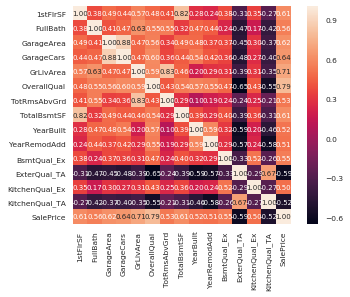

In [40]:
data_train.SalePrice = data_train.SalePrice.apply(float)

# Train data(dummy)로 corrmat 생성
corrmat = data_train.corr()

# 생성된 corrmat 중 SalePrice와의 연관이 0.5 이상인 columns 추출
corr_up = np.where(abs(corrmat['SalePrice'])>0.5)
predict_cols = corrmat['SalePrice'][list(corr_up[0])].keys()

display(corrmat['SalePrice'][predict_cols])
display(corrmat['SalePrice'][predict_cols].shape)

cm = np.corrcoef(data_train[predict_cols].values.T)
sns.set(font_scale=0.75)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 7}
                 , yticklabels=predict_cols.values, xticklabels=predict_cols.values)
plt.show()